In [1]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]

def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 20.9 GB  | Proc size: 54.4 MB
GPU RAM Free: 2011MB | Used: 37MB | Util   2% | Total 2048MB


In [5]:
import pathlib
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
!ls 'drive/MyDrive/Studio/Deep Learning/kaggle/1_Courses/1_Computer Vision/datasets/car-or-truck/train'

Car  Truck


In [1]:
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.computer_vision.ex6 import *

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
train_dataset_dir = './datasets/car-or-truck/train'
valid_dataset_dir = './datasets/car-or-truck/valid'
ds_train_ = image_dataset_from_directory(
    train_dataset_dir,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True)
ds_valid_ = image_dataset_from_directory(
    valid_dataset_dir,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [9]:
!pip install tf-nightly

     |████████████████████████████████| 488.0 MB 16 kB/s 
     |████████████████████████████████| 462 kB 48.8 MB/s 
     |████████████████████████████████| 1.4 MB 38.4 MB/s 
     |████████████████████████████████| 5.8 MB 34.1 MB/s 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

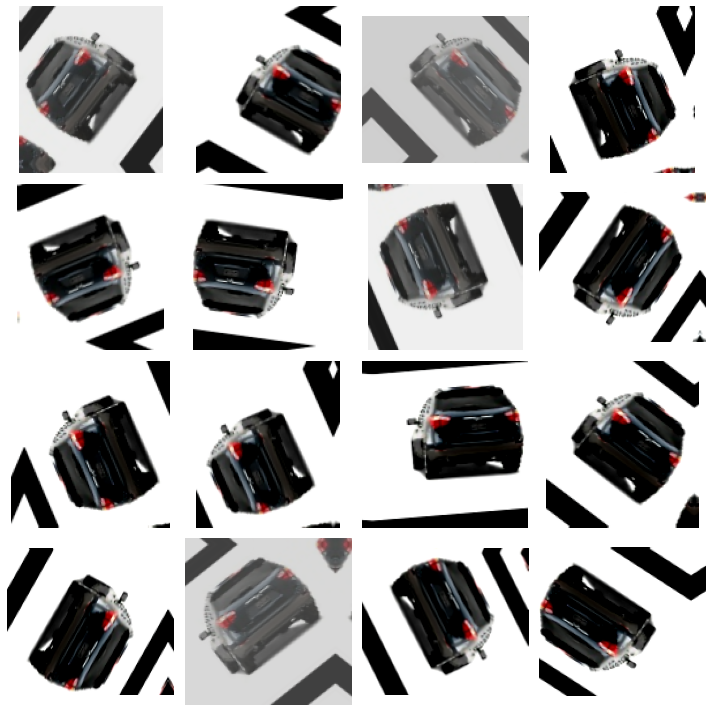

In [2]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    preprocessing.RandomRotation(factor=0.20),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

# tf.config.experimental.enable_op_determinism()
ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [3]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

Epoch 1/50
80/80 [==============================] - 116s 1s/step - loss: 0.6744 - binary_accuracy: 0.5785 - val_loss: 0.6726 - val_binary_accuracy: 0.5785
Epoch 2/50
80/80 [==============================] - 71s 887ms/step - loss: 0.6671 - binary_accuracy: 0.5765 - val_loss: 0.6508 - val_binary_accuracy: 0.5785
Epoch 3/50
80/80 [==============================] - 73s 919ms/step - loss: 0.6558 - binary_accuracy: 0.5787 - val_loss: 0.6426 - val_binary_accuracy: 0.5783
Epoch 4/50
80/80 [==============================] - 74s 933ms/step - loss: 0.6295 - binary_accuracy: 0.6078 - val_loss: 0.6187 - val_binary_accuracy: 0.6510
Epoch 5/50
80/80 [==============================] - 73s 914ms/step - loss: 0.6235 - binary_accuracy: 0.6684 - val_loss: 0.6320 - val_binary_accuracy: 0.6472
Epoch 6/50
80/80 [==============================] - 76s 958ms/step - loss: 0.5934 - binary_accuracy: 0.6969 - val_loss: 0.6054 - val_binary_accuracy: 0.6836
Epoch 7/50
80/80 [==============================] - 73s 910m

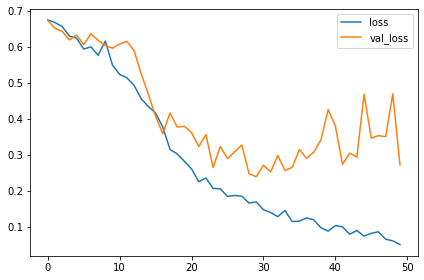

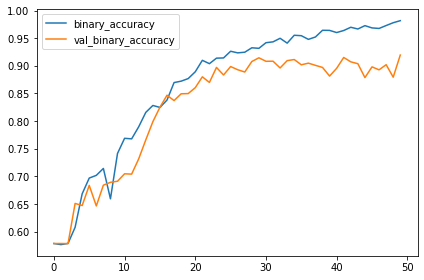

In [4]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [5]:
pip install pyyaml h5py

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [7]:
# Check its architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_1 (RandomCon (None, 128, 128, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 3)       21        
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)       